In [1]:
from torch.cuda import empty_cache as empty_cuda_cache, is_available as is_cuda_available
from torch.mps import empty_cache as empty_mps_cache
from torch.backends.mps import is_available as is_mps_available
from gc import collect

def reset_model(model, has_model: bool = True):
    if is_cuda_available(): empty_cuda_cache()
    elif is_mps_available(): empty_mps_cache()
    
    if has_model: del model

    collect()
    globals().clear()

%reset -f

In [2]:
from IPython.display import clear_output
from ultralytics import checks

clear_output()
checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.11.8 torch-2.2.2 CPU (Apple M3 Max)
Setup complete ✅ (16 CPUs, 64.0 GB RAM, 658.7/1858.2 GB disk)


In [3]:
from subprocess import run, PIPE

def run_command(command: str, **kwargs):
    """
    Run command with optional arguments. Examples:
    
    run_command("yolo", task="detect", mode="predict")
    run_command("yolo task=detect mode=predict")

    Args:
        command (str): Command to be run
    """
    if not kwargs:
        cmd = command.split(" ")    

    else:
        cmd = [ command ]
        for key, value in kwargs.items():
            cmd.append(f"{key}={value}")

    result = run(cmd, stdout = PIPE)
    output = result.stdout.decode()
    print(output)
    #return output

## Inference with Model

In [4]:
from torch import device
from torch.cuda import is_available as is_cuda_available
from torch.backends.mps import is_available as is_mps_available

BACKEND = "mps" if is_mps_available() else "cuda" if is_cuda_available() else "cpu"
DEVICE = device(BACKEND)
print(f"Device: {DEVICE} ({BACKEND})")

Device: mps (mps)


In [5]:
from os import getcwd
from os.path import abspath, join

HOME = abspath(join(getcwd(), ".."))
print(HOME)

/Users/kiran/Documents/workspace/Projects/algae-detection


In [6]:
from IPython.display import Image, display

test_img = f"{HOME}/dog.jpeg"

def output_img(path, height=600):
    display(Image(filename=path, width=height, height=height))

# output_img(test_img)

## Get custom dataset

In [42]:
from roboflow import Roboflow

rf = Roboflow(api_key="YOUR_API_KEY") # replace with your roboflow API key
project = rf.workspace("capstone2algae").project("algae-detection-1opyx")
VERSION = 9
version = project.version(VERSION)
#dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
if DEVICE == "mps":
    from os import cpu_count
    from json import loads

    out = loads(run_command("system_profiler -json -detailLevel mini SPDisplaysDataType")) # type: ignore
    gpus = int(out['SPDisplaysDataType'][0]['sppci_cores'])
    cpus = cpu_count()

## Custom Training

In [20]:
%cd {HOME}

yolov8_weights= f"{HOME}/model_weights/yolov8n.pt"
confidence = 0.25
epochs = 3
img_size = 256

/Users/kiran/Documents/workspace/Projects/algae-detection


In [25]:
from torch.mps import empty_cache
empty_cache()

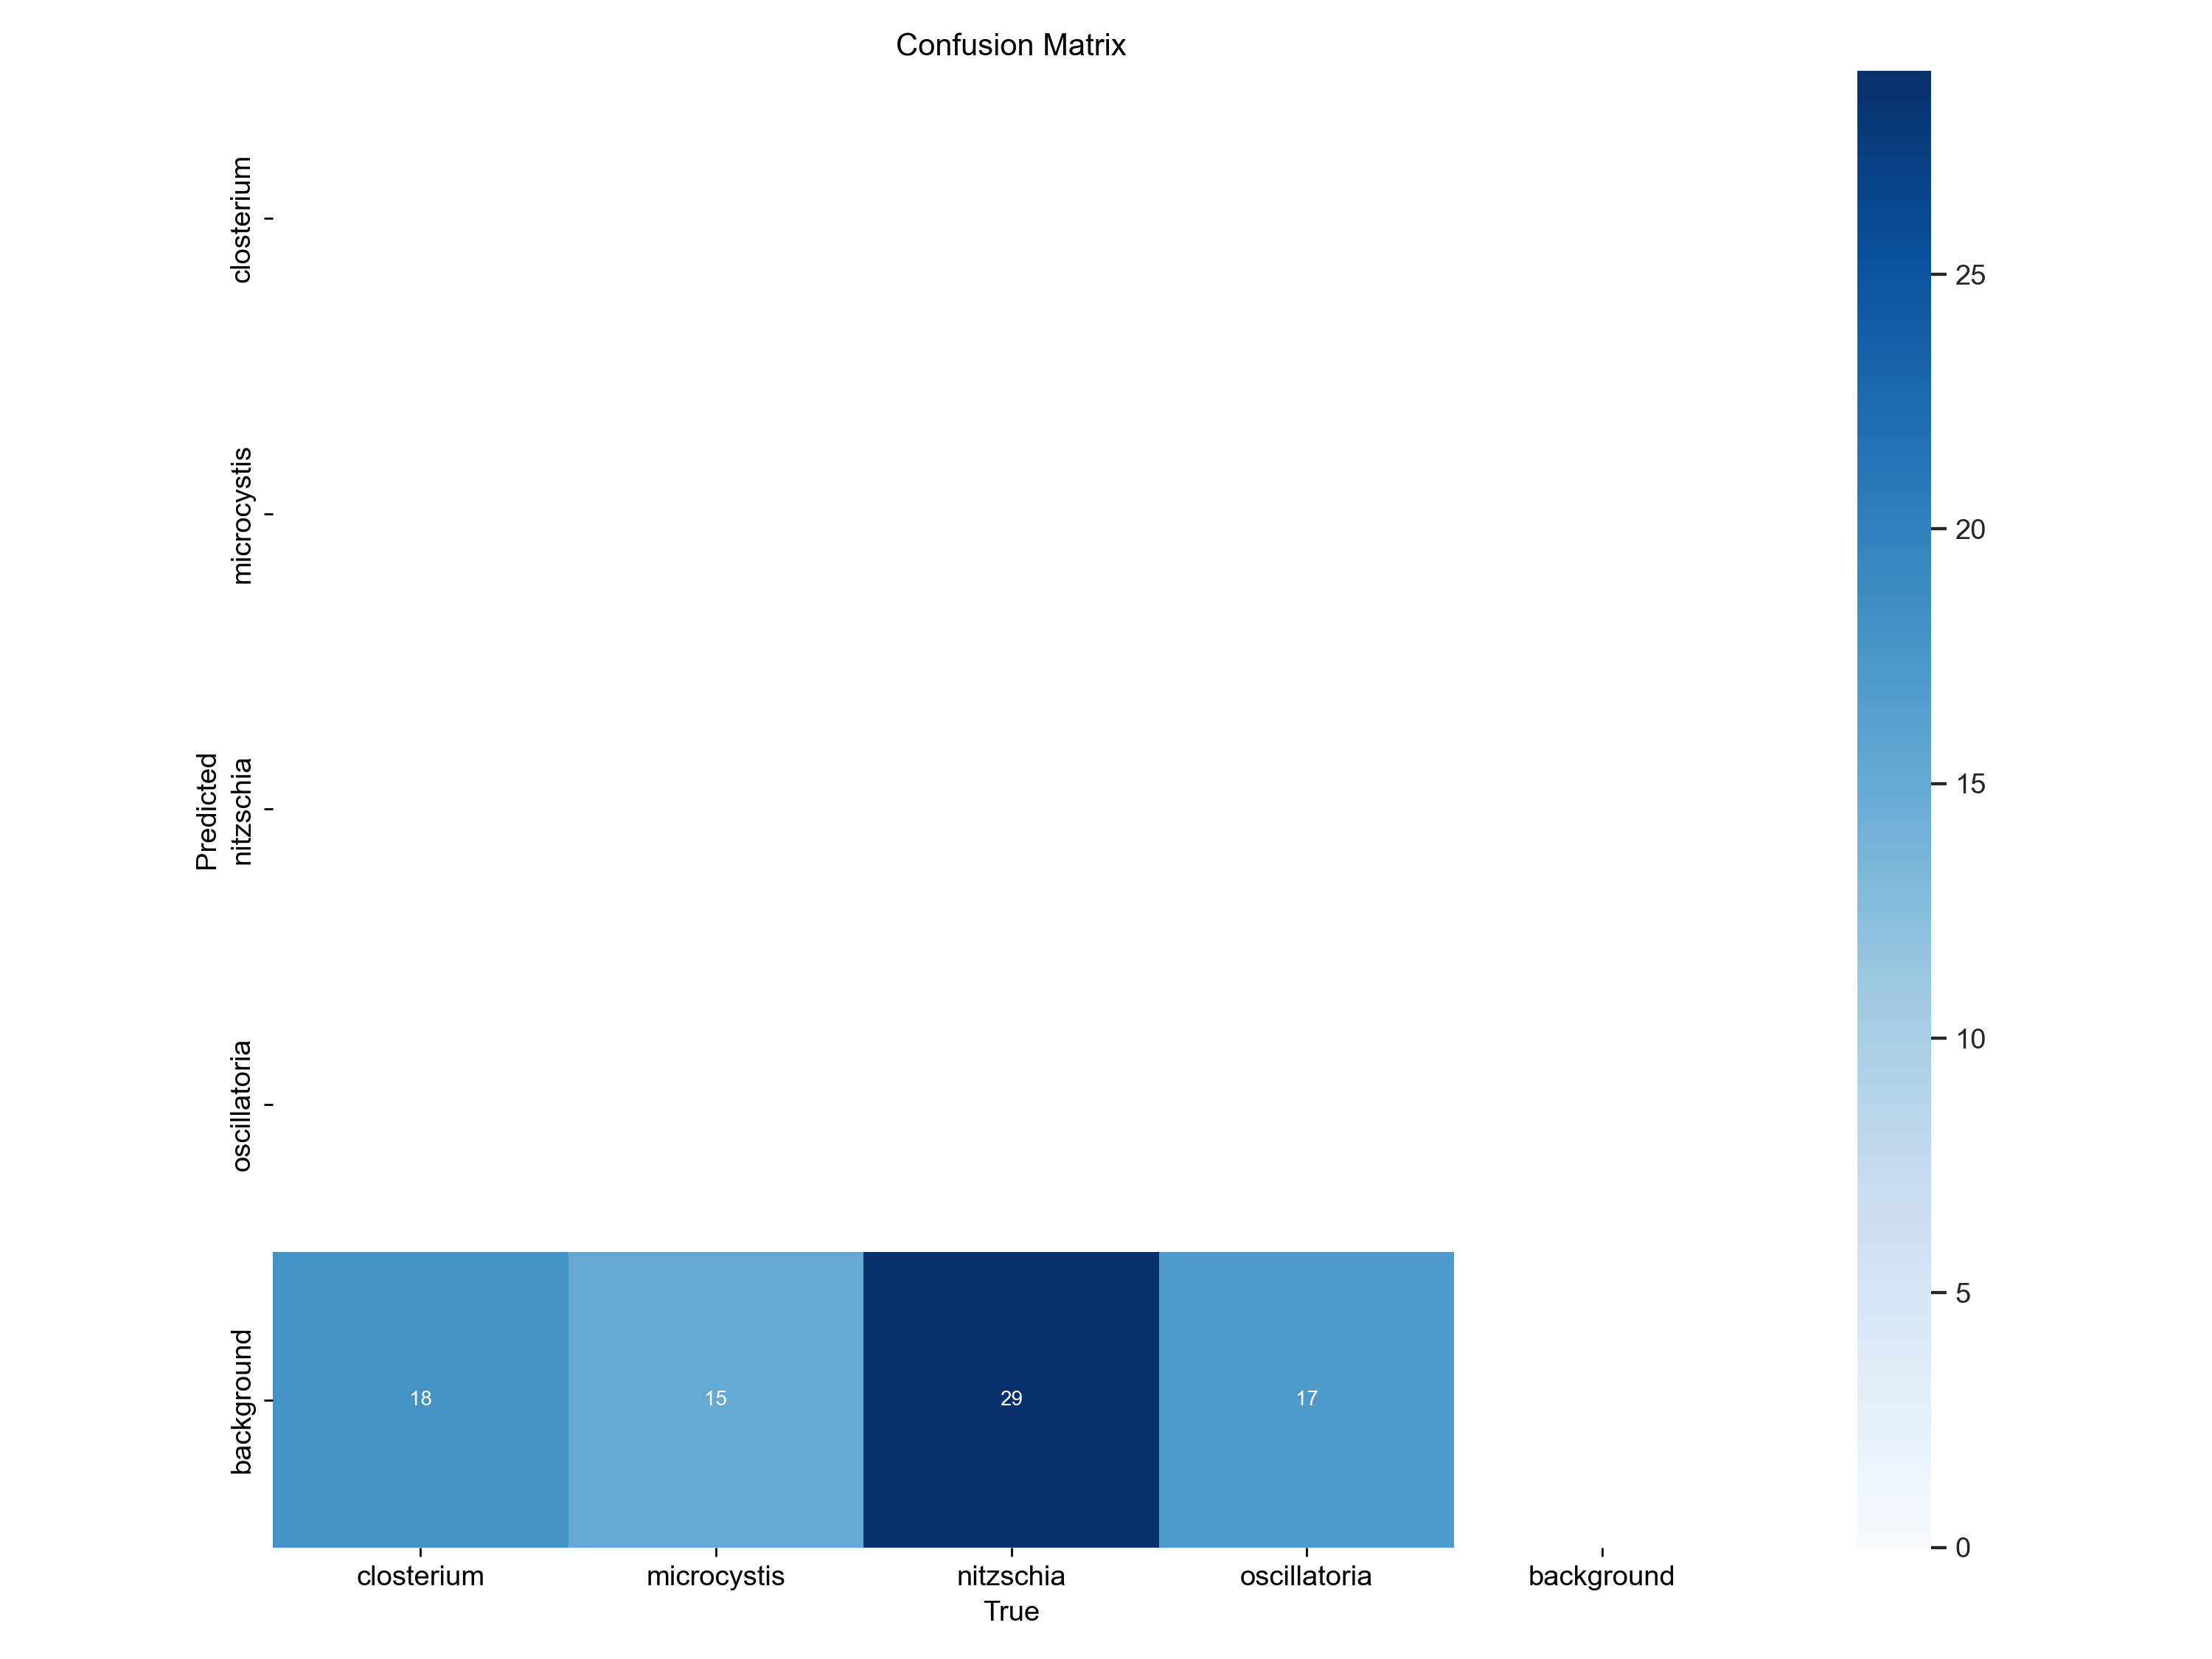

In [18]:
output_img(f'{HOME}/runs/detect/train2/confusion_matrix.png', 600)

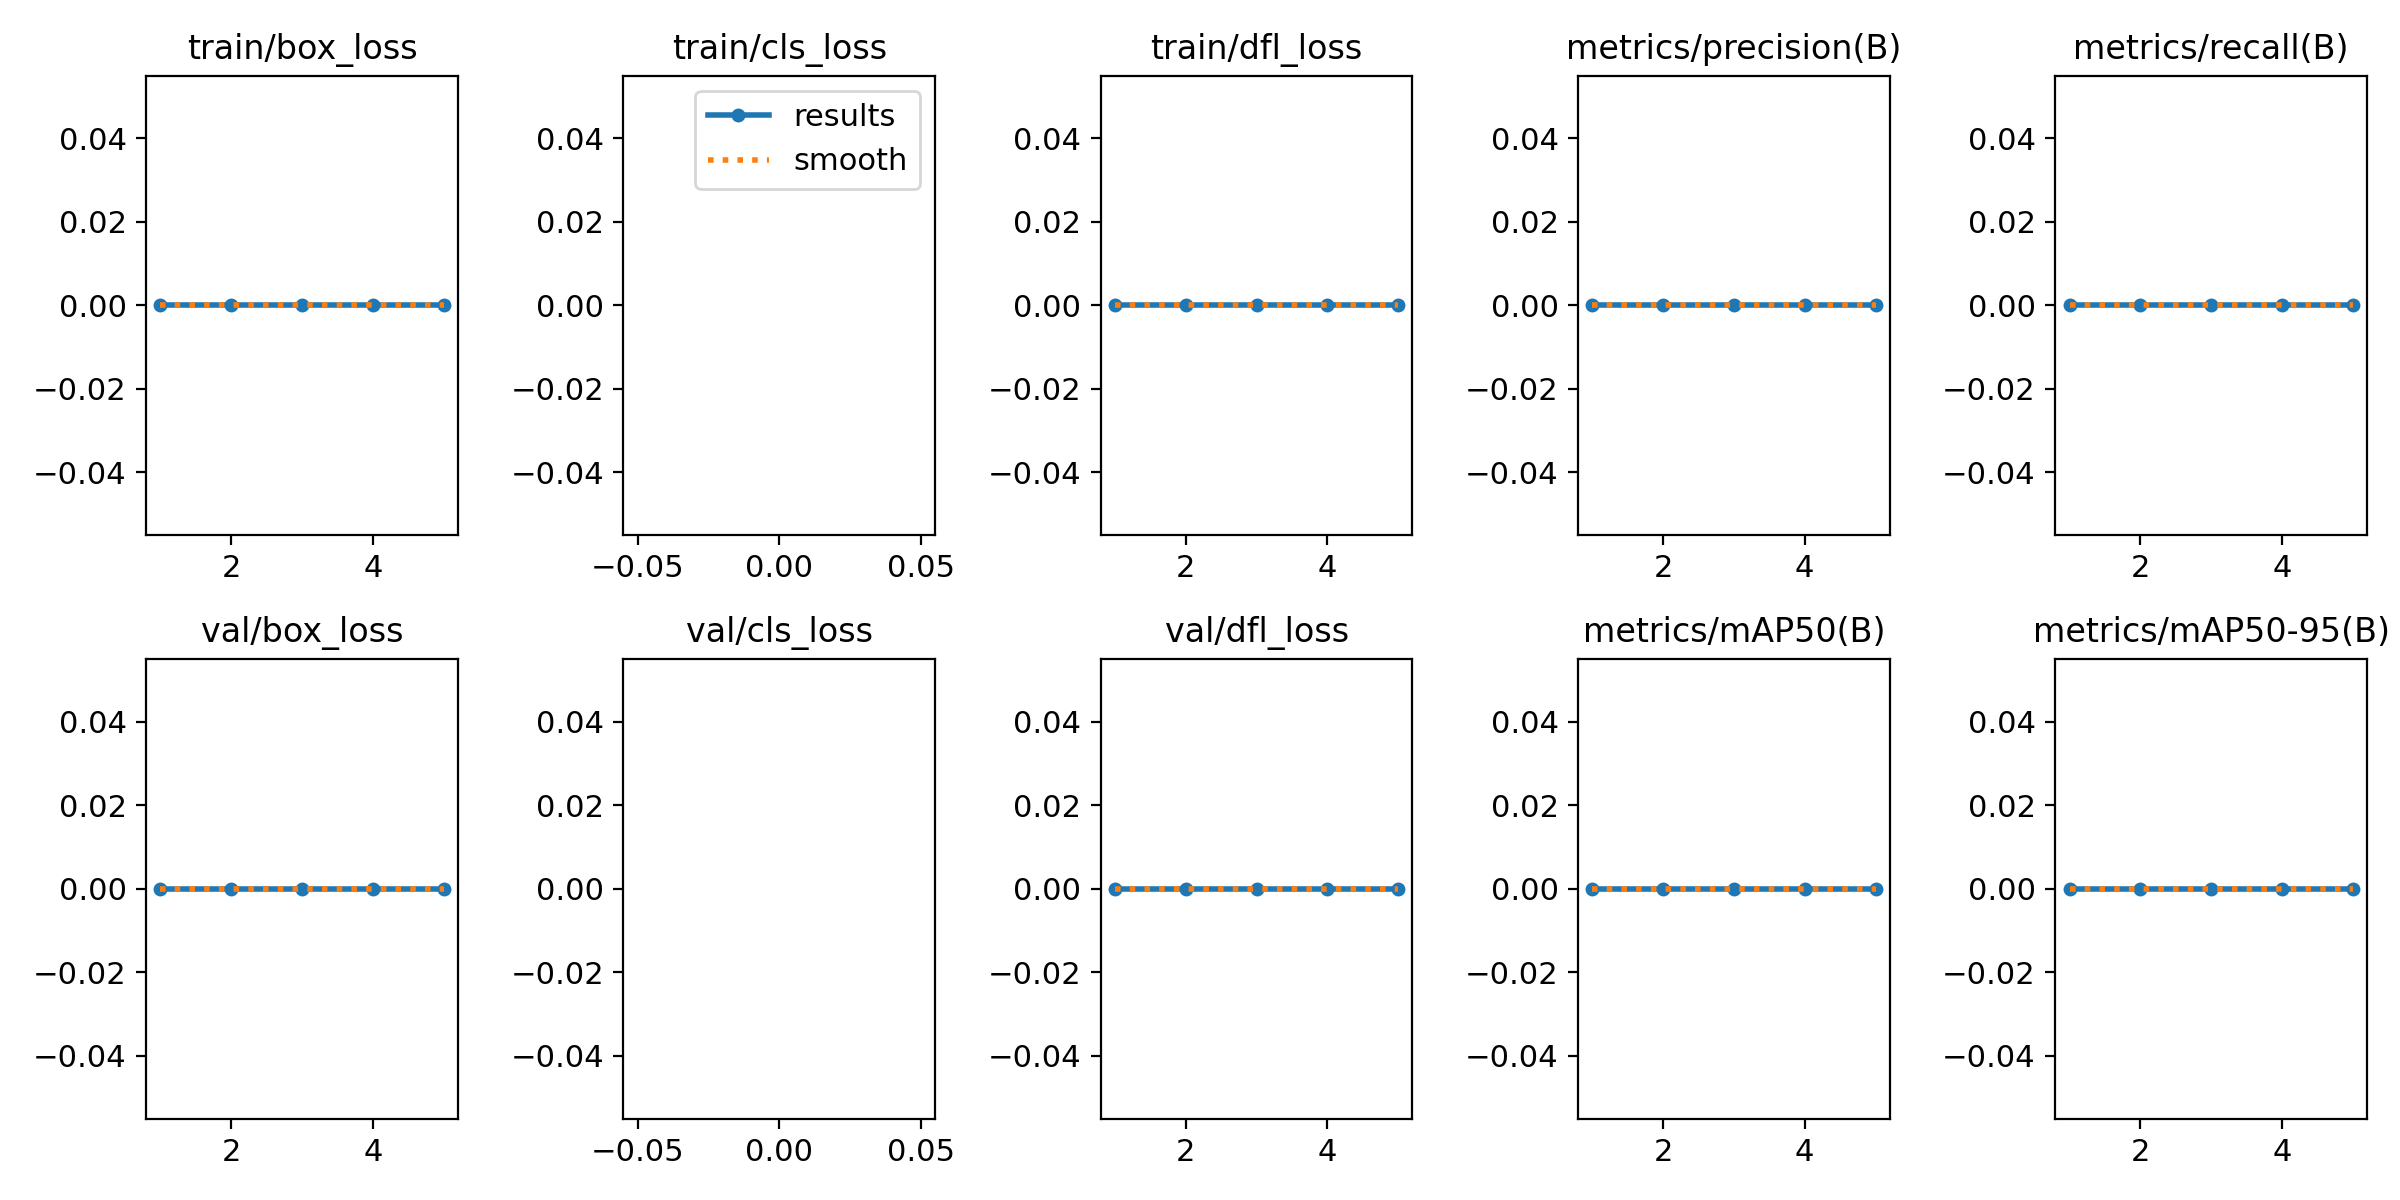

In [19]:
output_img(f'{HOME}/runs/detect/train2/results.png', 600)

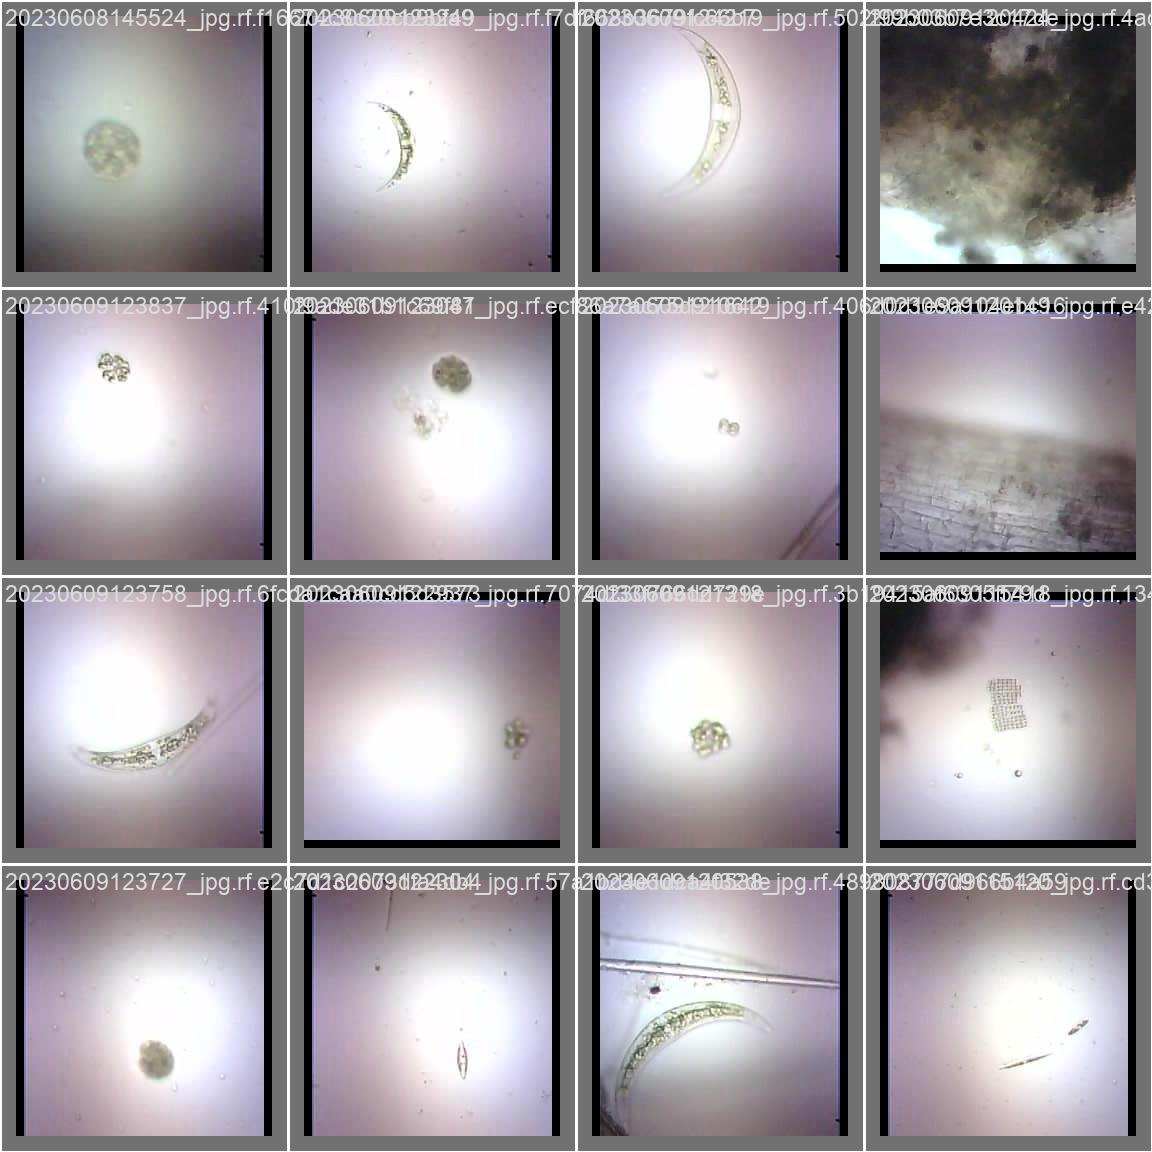

In [20]:
output_img(f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', 600)

## Validate Custom Model

In [21]:
run_command(f"yolo task=detect mode=val plots=True imgsz={img_size} device={DEVICE} model={HOME}/runs/detect/train2/weights/best.pt data={ds_location}/data.yaml")

Ultralytics YOLOv8.0.196 🚀 Python-3.11.8 torch-2.2.2 MPS (Apple M3 Max)
Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /Users/kiran/Documents/workspace/Projects/algae-detection/algae_ds/valid/labels.cache... 82 images, 15 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
                   all         82         79          0          0          0          0
Speed: 0.3ms preprocess, 27.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with Custom Model

**NOTE:** Let's take a look at few results.

In [30]:
from glob import glob

for image_path in glob(f'{HOME}/runs/detect/predict3/*.jpg'):
      output_img(image_path)
      print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv8 weights.

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [43]:
project.version(VERSION).deploy(model_type="yolov8", model_path=f"{HOME}", filename="model_weights/best_sahi_v1.pt")

#version.deploy("yolov8", "model_weights", "best.pt")

View the status of your deployment at: https://app.roboflow.com/capstone2algae/algae-detection-1opyx/9
Share your model with the world at: https://universe.roboflow.com/capstone2algae/algae-detection-1opyx/model/9


In [41]:
#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(VERSION).model

#choose random test set image
from os import listdir
from random import choice

#model = YOLO(model = f"/Users/kiran/Documents/workspace/Projects/algae-detection/model_weights/best.pt", task = "predict")

ds_location = "algae_ds"
#run_command(f"yolo task=detect mode=predict imgsz={img_size} model={HOME}/runs/detect/train2/weights/best.pt source={ds_location}/test/images device={DEVICE} save=True")

test_set_loc = f"{ds_location}/test/images/"
random_test_image = choice(listdir(test_set_loc))
print(f"running inference on {random_test_image}")

model.predict(f"{test_set_loc}{random_test_image}").json() # type: ignore
#reset_model(model)

running inference on 20230609095008_jpg.rf.e5fcc5b326446114316e5422b3f3a9d4.jpg


{'predictions': [], 'image': {'width': '256', 'height': '256'}}

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_thresh,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv5 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv5. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._